# NN Heston Model - Parameters Generation

In [52]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import math

from smt.sampling_methods import LHS
from sklearn.model_selection import train_test_split

In [53]:
import Cte
#
Seed    = Cte.parmsSeed
TAG     = Cte.parmsTAG

## Introduction

Pricing in mathematical finance is building a complex function from a model following some constraint.
Since models are just a rough description of markets, we accept the fact that each day we do 'calibrate'
models in order to match as much as possible what we see on the market. The complexity of the calibration procedure depends on the complexity of the underlying model deemed capable to describe the market situation. Most of the effort in applying neural networks to pricing has gone into the direction of devising 
clever shortcuts to the calibration mechanism.

We want to bypass this phase exploting the fact that pricing with a calibrated model amounts to 
the composition of two functions: one from market data to model parameters, the second from model 
paramters to market data. This approach is in itself not new. Some authors have attempted the path of walking directly from
market data to prices, leaving the model aside. In doing that they needed to train a network directly on market values. This approach required verylong time series and was able to train the netowrk only on quoted vanilla option.

In our approch, the assumption that the model, properly calibrated, is capable to describe the market with 
enough accuracy, is an essential element.

Given that we have outlined these concepts we can simply states the main goals of out work:

- dispose of the burden of having to calibrate models
- remove the need for ridiculously long time series of market data and option prices
- get rid of all of the computational bottlenecks when going from market to prices.

At this point, some of these goals need further explanation. That will come in due time. Let's start looking at a very simple example. For instance, if we resort to the Black-Scholes model:

\begin{align}
    dS_t &= S_t \sigma dW_t \nonumber
\end{align}

for a claim written on a single asset, all we have to do is to select the appropriate value for the volatility. And this is all is needed in terms of model calibration. If we are dealing with claims written on several assets, besides the volatility for each individual asset we have to decide on the correlations.

\begin{align}
    dS^i_t &= S^i_t \sigma^i dW^i_t \nonumber
\\ \mathbb{E}[ dW^i_t dW^j_t\,] &= \rho_{ij} dt \nonumber
\end{align}

Things get a lot more involved if we use more advanced models like stochastic volatility models. 
For example, if we adopt the Heston model: 

\begin{align}
    dS_t &= S_t \sqrt{\nu_t} dW_t \nonumber
    \\ d\nu_t &= k ( \theta - \nu_t) dt + \eta\sqrt{\nu_t} dY_t, \quad \nu_0 = \overline{\nu} \nonumber
\\ {\mathbb E}[ dW_t dY_t\,] &= \rho dt \nonumber
\end{align}

we have to calibrate the four parameters of the process of the stochastic volatility $(k, \theta, \nu_0, \eta)$ 
and the correlation term $(\rho)$ between the innovation processes.

Still more complex is the situation if we want to tackle some IR product. In that case, even using a very simple
model like the one factro Hull-White model:

\begin{align}
 dr(t) = k( \theta(t) - r(t) ) dt  + \sigma dW_t, \quad r(0) = r_o
\end{align}

besides parameters $(k, r_o, \sigma)$ we are asked to calibrate a whole curve $\theta(t)$
needed to match today's observed discount curve.

## Standard approach to ML

$\newcommand{\vect}[1]{{\mathbf{\boldsymbol{{#1}}}}}$
$\def\Em{\mathbb E}$

Let's call $\Pi( \vect{\alpha}, G(\vect{g}) )$ the function pricing a position $G$ with a model described
collectively by the parameters $\vect{\alpha}$, and the position described by the parameters $\vect{g}$. To be clear, in case of an option $\vect{g}$ could be the the pair maturity and strike. 

A standard ML exercise would call for 

- generating, according to some random rule, a set of parameters $\vect{\alpha}_n,\; \vect{g}_n\; 1 \le n \le N$,</li>
- for each $\vect{\alpha}_n\, \vect{g}_n$ compute the function pricing a derivative $G$ with a model described by the parameter set $\vect{\alpha}_n$. We define the total parameter set as  $\Pi_n := \Pi( \vect{\alpha}_n, G(\vect{g}_n))$
 
       
Iterating the procedure described above, we can build a large matrix 
    
 <table>   
     <tr>
         <th colspan="2">Features (Regressors)</th>
         <th>Label (Target)</th>
     </tr>
     <tr>
         <td> $\vect{\alpha}_1$</td> 
         <td> $\vect{g}_1 $    </td> 
         <td>    $\Pi_1$       </td>
     </tr>
     <tr>
         <td>$\vect{\alpha}_2$</td>
         <td>$\vect{g}_2 $    </td>
         <td>$\Pi_2$          </td>
     </tr>
     <tr> <td></td><td>...</td><td></td> </tr>
     <tr> 
         <td>$\vect{\alpha}_N$</td>
         <td>$\vect{g}_N $</td>
         <td>$\Pi_N$</td>
     </tr>
</table>
    
and use it to train a neural network that, if all goes well, will learn the map

\begin{equation}
    \phi_{NN}: \vect{\alpha}, \vect{g} \rightarrow \Pi(\vect{\alpha}, G).
\end{equation}     

## Generating Dataset

### Python support functions

#### Fonts Definition for Plotting Functions

In [54]:
SMALL_SIZE  = 8
MEDIUM_SIZE = 10
BIG_SIZE    = 12
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIG_SIZE)       # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


#### Plotting Functions

In [55]:
def histo_dict(df, TAG = '0000'):
    keys = list(df.keys())
    LEN = len(keys)
    fig, ax = plt.subplots(1,LEN, figsize=(12,6))
    for n in range(LEN):
        k     = keys[n]
        x     = df[k]
        lo   = np.min(x)
        hi   = np.max(x)
        bins = np.arange(lo, hi, (hi-lo)/100.)
        ax[n].hist(x, density=True, facecolor='g', bins=bins)
        ax[n].set_title("%s (len=%d)" %(k,len(x)))
        n += 1
    
    #plt.savefig("pdf_%s.png" %TAG, format="png")
    plt.savefig("param_pdf.png", format="png")
    plt.show()


In [56]:

def histo_params( x, title = "None"):
    keys = list(x)
    LEN  = len(keys)
    fig, ax = plt.subplots(1,LEN, figsize=(12,4))
    if not title == None: fig.suptitle(title)
    for n in range(LEN):
        tag  = keys[n]
        lo   = np.min(x[tag])
        hi   = np.max(x[tag])
        bins = np.arange(lo, hi, (hi-lo)/100.)
        ax[n].hist(x[tag], density=True, facecolor='g', bins=bins)
        ax[n].set_title(tag)
        n += 1
    plt.subplots_adjust(left=.05, right=.95, bottom=.10, top=.80, wspace=.50)
    plt.show()


#### Pricing Functions

This is the pricing function for the Heston Model we use in this example. The `Heston` class and the `ft_opt` function are defined in the `Lib` module. For a complete description of the Heston model refer to the Computational Finance Lecture Notes of Pietro Rossi.

In [57]:
from Lib.Heston import Heston
from Lib.FT_opt import ft_opt

def HestonPut(St, Strike, T, kappa, theta, sigma, v0, rho, r, Xc = 30):

    kT    = (Strike/St)*math.exp(-r*T)
    
    hestn = Heston(lmbda=kappa, eta=sigma, nubar=theta, nu_o=v0, rho=rho)
    res   = ft_opt(hestn, kT, T, Xc)
    
    return res['put'];

Make same simple pricing example...

In [58]:
'''
Model Parameters

Heston parameters:
    kappa  = volatility mean reversion speed parameter
    theta  = volatility mean reversion level parameter
    rho    = correlation between two Brownian motions
    sigma  = volatility of variance
    v0     = initial variance
'''
kappa  = 1.325  
theta  = 0.089 
sigma  = 0.231 
rho    = -0.9 
v0     = 0.153 

r      = 0.01
q      = 0.00
St     = 1.0
K      = 1.10
T      = 0.25

# the put price
HestonP = St * HestonPut(St, K, T, kappa, theta, sigma, v0, rho, r, 30)

# The call price by put-call parity
HestonC  = HestonP + St * math.exp(-q * T) - K * math.exp(-r * T)

In [59]:
print('Call price : ' + str(HestonC))
print('Put  price : ' + str(HestonP))

Call price : 0.03695376402274331
Put  price : 0.13420719865994957


#### Latin Hypercube Sampling Function

Before explaining the details of the creation of the synthetic dataset, we will
describe a statistical method for generating uniform random variables that
are not independent. As we will see, variables drawn using this method are
more spread out than independent uniform variables. Assume without loss
of generality that we wish to draw N random variables in $[0; 1]^d$. The latin
hypercube sampling ([McKay, 1992]) proceeds in this way:

<!--
<div>
<img src='../07-pictures/03_intro_to_deep_learning_pic_0.png'  width="600">
</div>
-->
![caption](./pic/heston-1.png)

To get the general case we can just apply a translation followed by a
scaling transformation to each sample. An example of the application of LHS
can be seen in the next figure

<!--
<div>
<img src='../07-pictures/03_intro_to_deep_learning_pic_0.png'  width="600">
</div>
-->
![caption](./pic/heston-2.png)

***Comparison between LHS and uniform 2d sampling of 10 points.
Notice how for every column and every row, there is only one point in the
LHS sample***

In [60]:
def lhs_sampling(rand, NUM, bounds=None):

    mInt = (1 << 15)
    MInt = (1 << 16)
    kw = list(bounds)

    # builds the array of bounds
    limits = np.empty( shape=(0,2) )
    for k in kw: limits = np.concatenate((limits, [bounds[k]]), axis=0)

    sampling = LHS(xlimits=limits, random_state=rand.randint(mInt,MInt))
    x   = sampling(NUM)

    X = pd.DataFrame()
    for n in range(len(kw)):
        tag = kw[n]
        X[tag] = x[:,n]


    y = np.where( 2*X["k"]*X["theta"] < np.power( X["sigma"], 2), 1, 0)
    p = (100.*np.sum(y))/NUM
    print("@ %-34s: %s = %6d out of %6d ( %.7f %s)" %("Info", "Feller violations", np.sum(y), NUM, p, "%"))

    return X


#### Function for parameters generation

In [61]:
def parms_gen( lhs = None, Xc=10, strikes=None):

    if lhs is None: raise Exception("No data to process")
    x = lhs

    NUM = len(x["T"])

    X = pd.DataFrame()
    for tag in list(x):
        X[tag] = np.full(NUM,0.0, dtype = np.double)
    X["Price"] = np.full(NUM,0.0, dtype = np.double)
    
    __tStart = time.perf_counter()
    pCount = 0
    cCount = 0
    n      = 0
    
    for m in range(NUM):
        Fw    = 1.0
        K     = x["Strike"][m]

        fwPut = HestonPut( St     = Fw
                         , Strike = K
                         , T      = x["T"][m]
                         , kappa  = x["k"][m]
                         , theta  = x["theta"][m]
                         , sigma  = x["sigma"][m]
                         , v0     = x["v0"][m]
                         , r      = 0 
                         , rho    = x["rho"][m]
                         , Xc     = Xc)
        
        if fwPut < max(K-Fw,0.): 
            pCount += 1
            continue

        for tag in list(x):
            X[tag][n] = x[tag][m]
        X["Price"][n] = fwPut
        n += 1
        # ---------------------------------------

    __tEnd = time.perf_counter()
    print("@ %-34s: elapsed %.4f sec" %("Seq. pricing", __tEnd - __tStart) )

    # Trim the original vector ....
    nSamples = n

    df = pd.DataFrame()
    for s in X.keys(): df[s] = np.copy(X[s][0:nSamples])
    print("@ %-34s: Violations Put=%d, Call=%d DB=%d out of %d" %("Info", pCount, cCount, nSamples, NUM))
    return df


### Generates and displays random parameters

**Constant Definition**

In [62]:

    verbose = False
    
    outputPrfx    = "full"
    testPrfx      = "test"
    targetPrfx    = "trgt"
    
    EPS           = 0.01
    XC            = 10.0 
    
    # bounds for the random generation of model parameters
    # and contract parameters
    bounds = { "k":       [ .01   , 1.00]
             , "theta":   [ .01   ,  .80]
             , "sigma":   [ .01   , 1.00]
             , "v0":      [ .01   ,  .80]
             , "rho":     [-.99   , 0.00]
             , "T":       [ 1./12., 2.00]
             , "Strike":  [ .6    , 1.40]
             }

    NUM     = 100000
    mInt    = (1 << 15)
    MInt    = (1 << 16)
    rand    = np.random.RandomState(Seed)
    
    # strikes used to build the smile used as a regressor
    strikes = np.arange(.8, 1.2, .025)

@ Info                              : Feller violations =  43950 out of 100000 ( 43.9500000 %)
@ LHS                               : elapsed 0.1005 sec


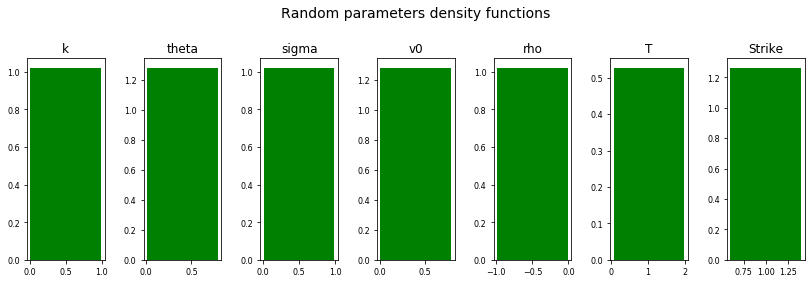

In [63]:
   
    __tStart = time.perf_counter()
    xDF = lhs_sampling(rand, NUM, bounds = bounds)
    __tEnd = time.perf_counter()
    print("@ %-34s: elapsed %.4f sec" %("LHS", __tEnd - __tStart) )

    # Let's check the distribution of the parameters we have generated
    histo_params( xDF, title = "Random parameters density functions")

   

**Generate random DB**

In [64]:
    # Generate training/test set
    __tStart = time.perf_counter()
    df =  parms_gen( lhs = xDF, Xc=XC, strikes = strikes)
    __tEnd = time.perf_counter()
    print("@ %-34s: elapsed %.4f sec" %("GEN", __tEnd - __tStart) )


@ Seq. pricing                      : elapsed 738.5374 sec
@ Info                              : Violations Put=32, Call=0 DB=99968 out of 100000
@ GEN                               : elapsed 738.5880 sec


In [65]:
df.head(10)

,k,theta,sigma,v0,rho,T,Strike,Price
0,0.582908,0.583583,0.373167,0.516915,-0.970304,1.256745,0.923284,0.257695
1,0.577928,0.495459,0.936467,0.345975,-0.447386,0.280740,1.367844,0.390239
2,0.362237,0.592558,0.667256,0.320355,-0.248208,0.140364,0.689468,0.003841
3,0.643486,0.084604,0.136309,0.505302,-0.274690,1.251839,0.921788,0.218513
4,0.694362,0.249374,0.564682,0.772275,-0.187729,1.636092,0.887876,0.282851
5,0.303223,0.158998,0.753198,0.406268,-0.087679,0.604235,1.096652,0.243603
6,0.721637,0.278406,0.236576,0.390247,-0.811191,0.855779,0.803540,0.114664
7,0.496986,0.136317,0.867226,0.436327,-0.958365,1.950080,1.062892,0.267544
8,0.432537,0.017438,0.216519,0.175533,-0.703677,1.948892,1.320964,0.397159
9,0.591481,0.734197,0.556445,0.366618,-0.371790,1.950406,1.273612,0.557915


Select a random subset as a challenge set

In [66]:
X_train, X_test = train_test_split(df, test_size=0.33, random_state=rand.randint(mInt,MInt))

Add some noise to the training set

In [67]:
# Add some noise to the training set
if EPS > 0.0:
    X_train_n = X_train.copy()
    xl = np.min(X_train["Price"])
    xh = np.max(X_train["Price"])

    xi = rand.normal( loc = 0.0, scale = EPS*(xh-xl), size=X_train.shape[0])
    X_train_n["Price"] += xi
else: X_train_n = X_train

Display the amount of noise

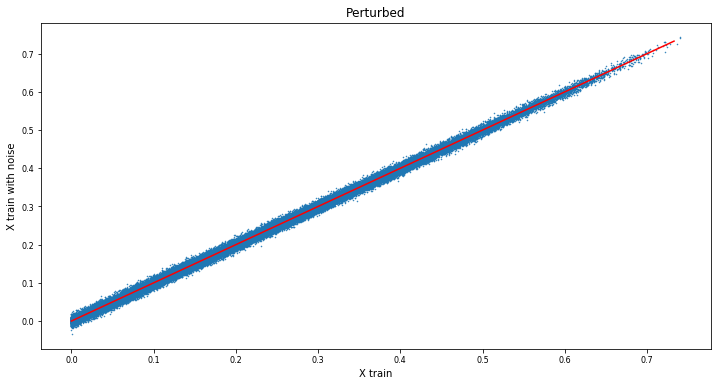

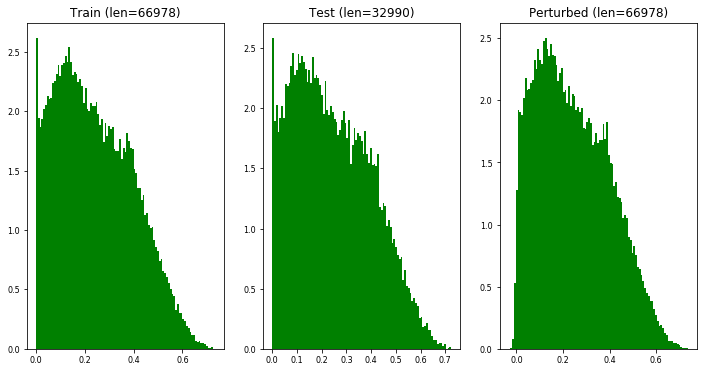

In [68]:
import warnings
warnings.simplefilter('ignore')

# Check the dispersion
if EPS > 0.0:
    xMin = 0.0
    xMax = max(X_train["Price"])
    v = np.arange(xMin, xMax, (xMax - xMin)/100.)

    fig, ax = plt.subplots(1,1, figsize=(12,6))

    ax.plot( X_train["Price"], X_train_n["Price"], ".", markersize=1)
    ax.plot( v, v, color="red")
    ax.set_title("Perturbed")
    ax.set_xlabel("X train")
    ax.set_ylabel("X train with noise")

    #figName = "scatter_%s.png" %(TAG)
    figName = "scatter_noise.png" 
    plt.savefig(figName, format="png")
    plt.show()
    histo_dict( {"Train"    : np.array(X_train["Price"]), 
                 "Test"     : np.array(X_test["Price"]), 
                 "Perturbed": np.array(X_train_n["Price"]) }, TAG=TAG)
else:
    histo_dict( {"Train": np.array(X_train["Price"]), "Test": np.array(X_test["Price"]) }, TAG=TAG )

remove the target from the test set

In [69]:
    Y = pd.DataFrame({"Price": X_test["Price"]})
    X_test = X_test.drop(columns="Price")

### Saving dataset to disk

write training set to disk

In [70]:
    TAG = '0000'
    outputFile = "%s_%s.csv" %(outputPrfx, TAG)
    X_train_n.to_csv(outputFile, sep=',', float_format="%.6f", index=False)
    print("@ %-34s: training data frame written to '%s'" %("Info", outputFile))
    if verbose: print(outputFile); print(X)

@ Info                              : training data frame written to 'full_0000.csv'


write challenge set to disk

In [71]:
    challengeFile = "%s_%s.csv" %(testPrfx, TAG)
    X_test.to_csv(challengeFile, sep=',', float_format="%.6f", index=False)
    print("@ %-34s: challenge data frame written to '%s'" %("Info", challengeFile))
    if verbose: print(challengeFile); print(X_train)

@ Info                              : challenge data frame written to 'test_0000.csv'


write target to disk

In [72]:
    targetFile = "%s_%s.csv" %(targetPrfx, TAG)
    Y.to_csv(targetFile, sep=',', float_format="%.6f", index=False)
    print("@ %-34s: target data frame written to '%s'" %("Info", targetFile))
    if verbose: print(targetFile); print(Y)

@ Info                              : target data frame written to 'trgt_0000.csv'
